# Baseline Models

In [79]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Patch
import seaborn as sns
import missingno as msno
import glob
import os


## Baseline Models for Rat Sightings Data

In [80]:
rs = pd.read_csv('../scr/data/cleaned_rat_sightings_data/cleaned_rat_sightings.csv')

In [81]:
# training data will be entries before 2025
# testing data will be on entries after 2025

rs['created_date'] = pd.to_datetime(rs['created_date']) 
rs['closed_date'] = pd.to_datetime(rs['closed_date'])
rs['resolution_action_updated_date'] = pd.to_datetime(rs['resolution_action_updated_date'])

rs = rs[rs['created_date']<='2025-12-31']
rs = rs[rs['created_date']>='2020-01-01']

rs_train = rs[rs['created_date']<'2025-01-01']
rs_test = rs[rs['created_date']>='2025-01-01']


### Baseline: Seasonal Average Forecast

Our EDA indicates that the number of rat sightings has seasonality, but no trend. We consider a baseline model of a seasonal average forecast i.e. we simply forecast the average of all observations in the past seaons. We assume here that each season is 1 year or 365 days long.

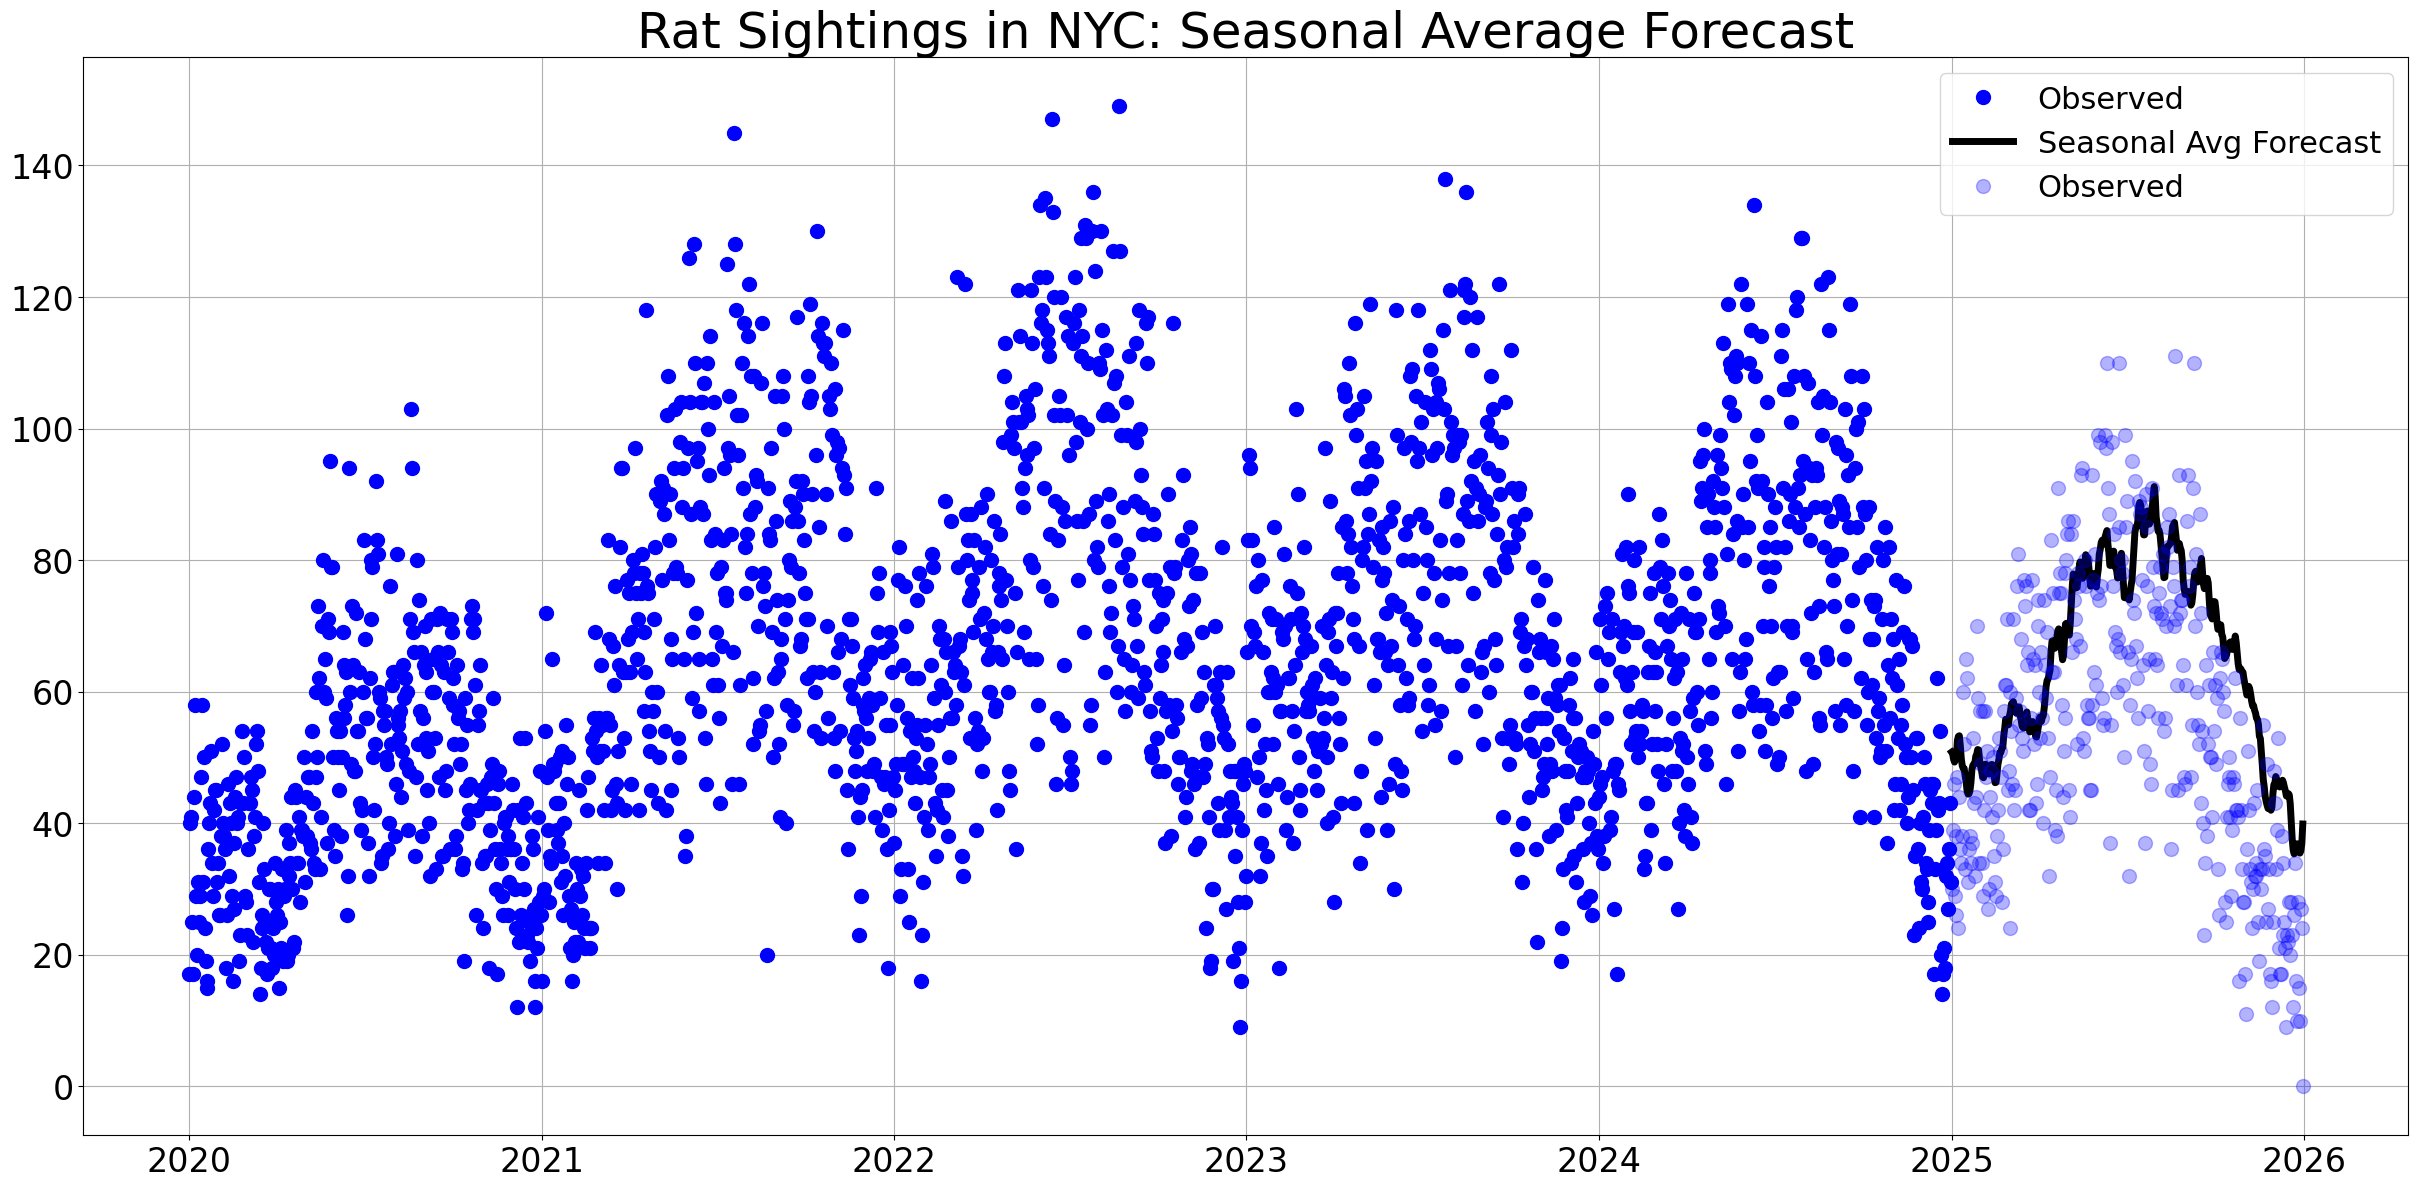


 The RMSE of our forecast against the test set is 19.275769008015136

 The RSS of our forecast against the test set is 368.26304981681267


In [82]:
nrs_test = rs_test.groupby([rs_test['created_date'].dt.date]).size().reset_index(name='count')

nrs_train = rs_train.groupby([rs_train['created_date'].dt.date]).size().reset_index(name='count')

full_range = pd.date_range(
    start="2020-01-01",
    end="2024-12-31",
    freq='D'
)

# reindex and fill missing dates with 0
nrs_train = (
    nrs_train
    .set_index('created_date')
    .reindex(full_range, fill_value=0)
    .rename_axis('created_date')
    .reset_index()
)

full_range = pd.date_range(
    start="2025-01-01",
    end="2025-12-31",
    freq='D'
)

# reindex and fill missing dates with 0
nrs_test = (
    nrs_test
    .set_index('created_date')
    .reindex(full_range, fill_value=0)
    .rename_axis('created_date')
    .reset_index()
)

def seasonal_average_forecast(data, target_dates, years_back=5, day_window=5):
    """
    data: DataFrame with columns ['created_date', 'count']
    target_dates: DatetimeIndex of future dates
    """
    df = data.copy()

    # ensure datetime type
    df["created_date"] = pd.to_datetime(df["created_date"])
    df["doy"] = df["created_date"].dt.dayofyear
    df["year"] = df["created_date"].dt.year

    forecasts = []
    for target_date in target_dates:
        target_doy = target_date.dayofyear
        target_year = target_date.year
        mask = (
            (df["year"] >= target_year - years_back) &
            (df["year"] < target_year) &
            (np.abs(df["doy"] - target_doy) <= day_window)
        )

        forecasts.append(df.loc[mask, "count"].mean())

    return pd.Series(forecasts, index=target_dates)


# define future dates
# number of years to forecast
years_to_forecast = 1

last_date = nrs_train["created_date"].max()
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=365 * years_to_forecast,
    freq="D"
)

fig = plt.figure(figsize=(30,14))

# compute seasonal-average forecast
# due to possibly sparse data, we use a window
forecast = seasonal_average_forecast(
        nrs_train,
        future_dates,
        years_back=5,
    )

    # plot observed data
plt.plot(
    nrs_train["created_date"],
    nrs_train["count"],
    "o",
    color="b",
    markersize=10,
    label="Observed"
    )

# plot forecast
plt.plot(
    forecast.index,
    forecast.values,
    color="black",
    linewidth=5,
    linestyle = "-",
    label="Seasonal Avg Forecast"
)

plt.plot(
    nrs_test["created_date"],
    nrs_test["count"],
    "o",
    color="b",
    markersize=10,
    alpha=0.3,
    label="Observed",
    )

plt.grid(True)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.legend(fontsize=22)
plt.title("Rat Sightings in NYC: Seasonal Average Forecast", fontsize=36)
plt.show()



rmse = np.sqrt(np.mean((nrs_test['count'] - forecast.values)**2))
rss = np.sqrt(np.sum((nrs_test['count'] - forecast.values)**2))

# note that nrs_test has no count for 2025-12-31
print(f"\n The RMSE of our forecast against the test set is {rmse}")
print(f"\n The RSS of our forecast against the test set is {rss}")


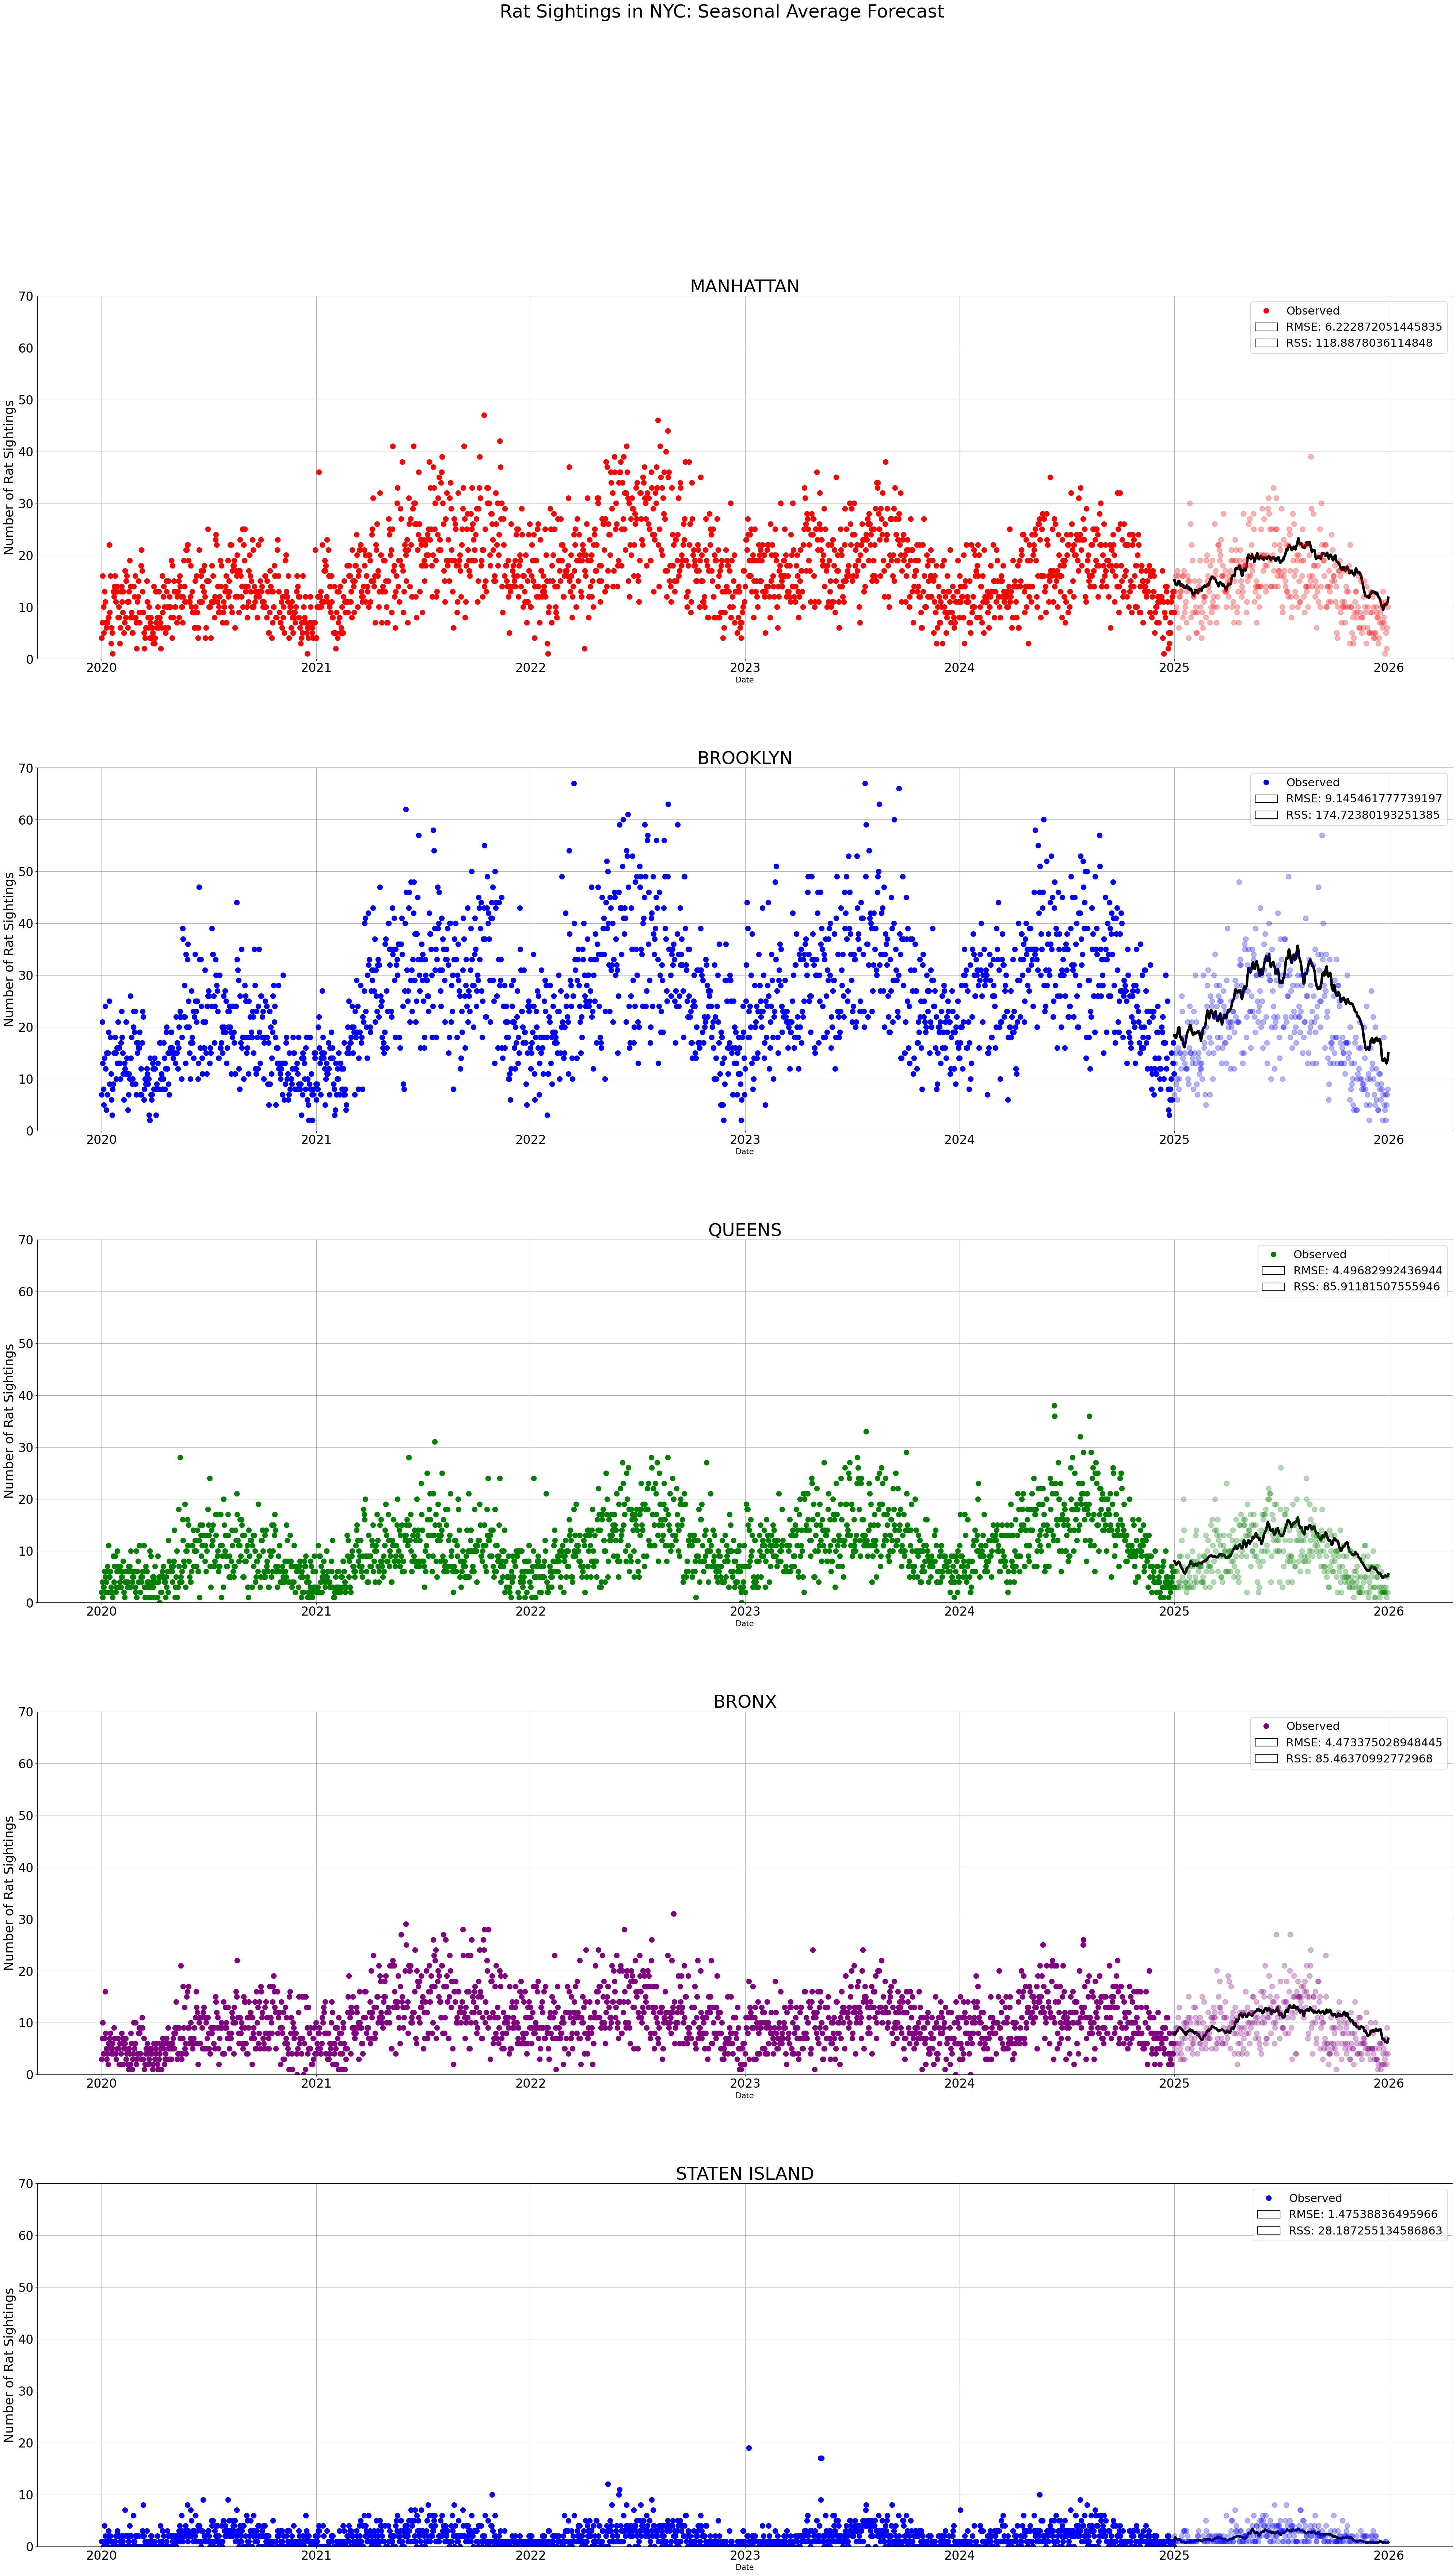

In [83]:
cdate_borough_test = rs_test.groupby([rs_test['created_date'].dt.date, 'borough']).size().reset_index(name='count')

cdate_borough = rs_train.groupby([rs_train['created_date'].dt.date, 'borough']).size().reset_index(name='count')
boroughs = [b for b in rs['borough'].unique() if pd.notnull(b) and b != 'Unspecified']


def seasonal_average_forecast(data, target_dates, years_back=5, day_window=5):
    """
    data: DataFrame with columns ['created_date', 'count']
    target_dates: DatetimeIndex of future dates
    """
    df = data.copy()

    # ensure datetime type
    df["created_date"] = pd.to_datetime(df["created_date"])
    df["doy"] = df["created_date"].dt.dayofyear
    df["year"] = df["created_date"].dt.year

    forecasts = []
    for target_date in target_dates:
        target_doy = target_date.dayofyear
        target_year = target_date.year
        mask = (
            (df["year"] >= target_year - years_back) &
            (df["year"] < target_year) &
            (np.abs(df["doy"] - target_doy) <= day_window)
        )

        forecasts.append(df.loc[mask, "count"].mean())

    return pd.Series(forecasts, index=target_dates)


# ensure global dataframe is datetime

cdate_borough["created_date"] = pd.to_datetime(cdate_borough["created_date"])

# define future dates
# number of years to forecast
years_to_forecast = 1

last_date = cdate_borough["created_date"].max()
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=365 * years_to_forecast,
    freq="D"
)

fig = plt.figure(figsize=(50,80))
gs = gridspec.GridSpec(5,1, figure=fig, wspace=0.3, hspace=0.3)

colors = ["r", "b", "g", "purple", "b"]

for i, borough in enumerate(boroughs):
    ax = fig.add_subplot(gs[i])

    # borough_data = (
    #     cdate_borough[cdate_borough["borough"] == borough]
    #     .sort_values("created_date")
    #     .copy()
    # )
    borough_data = (
    cdate_borough[cdate_borough["borough"] == borough]
    .assign(created_date=lambda df: pd.to_datetime(df["created_date"]))
    .sort_values("created_date")
    .set_index("created_date")
    )

    # create a complete daily date range
    full_range = pd.date_range(
        start="2020-01-01",
        end="2024-12-31",
        freq="D"
    )

    # reindex and fill missing days with 0
    borough_data = (
        borough_data
        .reindex(full_range)
        .assign(
            count=lambda df: df["count"].fillna(0),
            borough=borough
        )
        .rename_axis("created_date")
        .reset_index()
    )

    borough_data_test = (
        cdate_borough_test[cdate_borough_test["borough"] == borough]
        .sort_values("created_date")
        .copy()
    )

    # compute seasonal-average forecast
    # due to possibly sparse data, we use a window
    forecast = seasonal_average_forecast(
        borough_data,
        future_dates,
        years_back=5,
    )

    # plot observed data
    ax.plot(
        borough_data["created_date"],
        borough_data["count"],
        "o",
        color=colors[i],
        markersize=10,
        label="Observed"
    )

    # plot forecast
    ax.plot(
        forecast.index,
        forecast.values,
        color="black",
        linewidth=5,
        linestyle = "-",
        label="Seasonal Avg Forecast"
    )

    ax.plot(
        borough_data_test["created_date"],
        borough_data_test["count"],
        "o",
        color=colors[i],
        markersize=10,
        alpha=0.3,
        label="Observed",
    )

    actual_series = borough_data_test.set_index('created_date')['count']
    actual_aligned = actual_series.reindex(forecast.index, fill_value=0)

    rmse = np.sqrt(np.mean((actual_aligned - forecast.values)**2))
    rss = np.sqrt(np.sum((actual_aligned - forecast.values)**2))

    
    ax.set_title(f"{borough}", fontsize=35)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Number of Rat Sightings", fontsize=25)
    ax.grid(True)
    ax.set_ylim(0,70)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    text_box = Patch(facecolor='white', edgecolor='black', label=f'RMSE: {rmse}')
    text_box2 = Patch(facecolor='white', edgecolor='black', label=f'RSS: {rss}')
    ax.legend(handles=[ax.lines[0], text_box, text_box2], fontsize=22)
    
    

plt.suptitle("Rat Sightings in NYC: Seasonal Average Forecast", fontsize=36)
plt.show()





### Baseline: Seasonal Naive Forecast

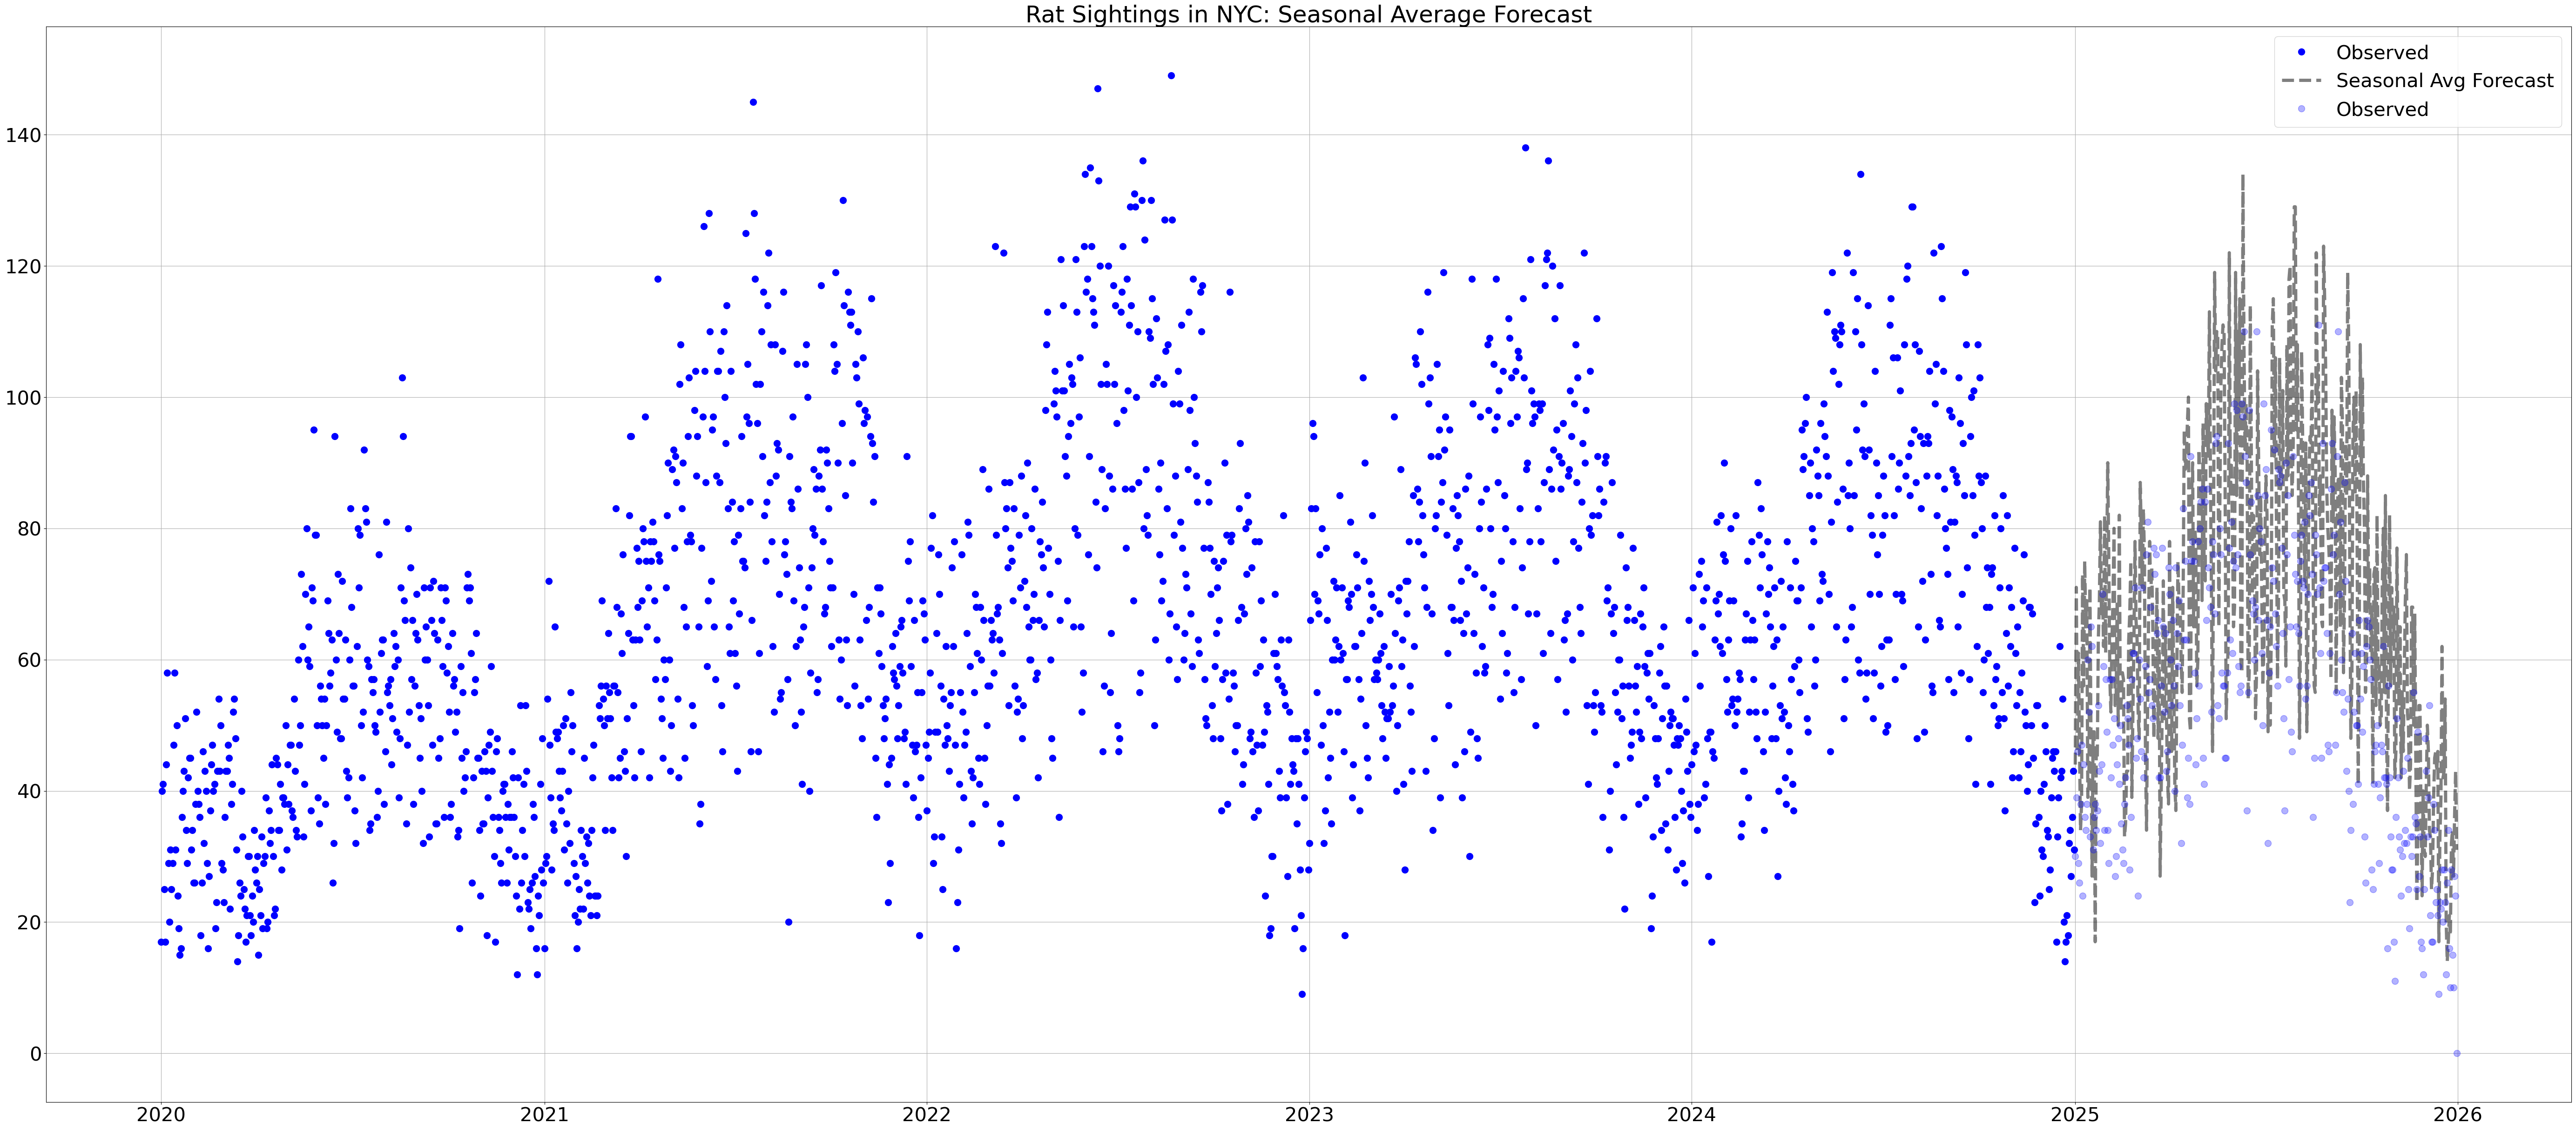


 The RMSE of our forecast against the test set is 26.60106085020228

 The RSS of our forecast against the test set is 508.21255395749523


In [84]:
fig = plt.figure(figsize=(70,30))

# plot observed data
plt.plot(nrs_train["created_date"], nrs_train["count"], "o",
    color="b", markersize=10, label="Observed")

# plot naive forecast

forecast = nrs_train[nrs_train['created_date']>="2024-01-01"]
forecast = forecast[forecast['created_date']!="2024-02-29"]
forecast['created_date'] = forecast['created_date'] + pd.DateOffset(years=1)


plt.plot(forecast['created_date'],forecast['count'], color="black",
    linewidth=5, linestyle = "--", alpha=0.5, label="Seasonal Avg Forecast")

plt.plot(nrs_test["created_date"], nrs_test["count"], "o",
    color="b", markersize=10, alpha=0.3, label="Observed",)

plt.grid(True)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.legend(fontsize=30)
plt.title("Rat Sightings in NYC: Seasonal Average Forecast", fontsize=36)
plt.show()


forecast = forecast.reset_index(drop=True)

rmse = np.sqrt(np.mean((nrs_test['count'] - forecast['count'])**2))
rss = np.sqrt(np.sum((nrs_test['count'] - forecast['count'])**2))

# note that nrs_test has no count for 2025-12-31
print(f"\n The RMSE of our forecast against the test set is {rmse}")
print(f"\n The RSS of our forecast against the test set is {rss}")



# Data Splits

In [85]:
from sklearn.model_selection import TimeSeriesSplit

Our cross-validation will work as follows. 

We first train on data from 2020-01-01 to 2020-12-31, and test using 2021-01-01 to 2021-12-31. Then we train on 2020-01-01 to 2021-12-13 and test from 2022-01-01 to 2022-12-13. We continue until we test on 2025-01-01 to 2025-12-13. 

In other words, our forecasting horizon is 1 year and so we have 6 splits.

In [86]:
kfold = TimeSeriesSplit(n_splits = 6,
                           test_size = 365)

In [87]:
df = rs.copy()
df["created_date"] = pd.to_datetime(df["created_date"])


# Convert dates to ordinal numbers
date_index = df["created_date"].map(pd.Timestamp.toordinal)

df = (
    df
    .sort_values("created_date", ascending=True)
    .reset_index(drop=True)
)

tscv = TimeSeriesSplit(n_splits=6)

for fold, (train_idx, test_idx) in enumerate(tscv.split(date_index)):
    train_dates = df.iloc[train_idx]["created_date"]
    test_dates = df.iloc[test_idx]["created_date"]
    print(f"Fold {fold + 1}")
    print("Train:", train_dates.min(), "→", train_dates.max())
    print("Test: ", test_dates.min(), "→", test_dates.max())
    print()

Fold 1
Train: 2020-01-01 03:24:58 → 2021-03-24 06:53:51
Test:  2021-03-24 07:35:07 → 2021-11-30 15:24:22

Fold 2
Train: 2020-01-01 03:24:58 → 2021-11-30 15:24:22
Test:  2021-11-30 15:43:06 → 2022-08-19 15:25:32

Fold 3
Train: 2020-01-01 03:24:58 → 2022-08-19 15:25:32
Test:  2022-08-19 15:46:26 → 2023-06-16 21:52:19

Fold 4
Train: 2020-01-01 03:24:58 → 2023-06-16 21:52:19
Test:  2023-06-16 23:03:03 → 2024-04-05 04:32:26

Fold 5
Train: 2020-01-01 03:24:58 → 2024-04-05 04:32:26
Test:  2024-04-05 04:33:49 → 2025-01-04 08:42:15

Fold 6
Train: 2020-01-01 03:24:58 → 2025-01-04 08:42:15
Test:  2025-01-04 09:29:23 → 2025-12-30 20:18:16



# SARIMA Models

In [88]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

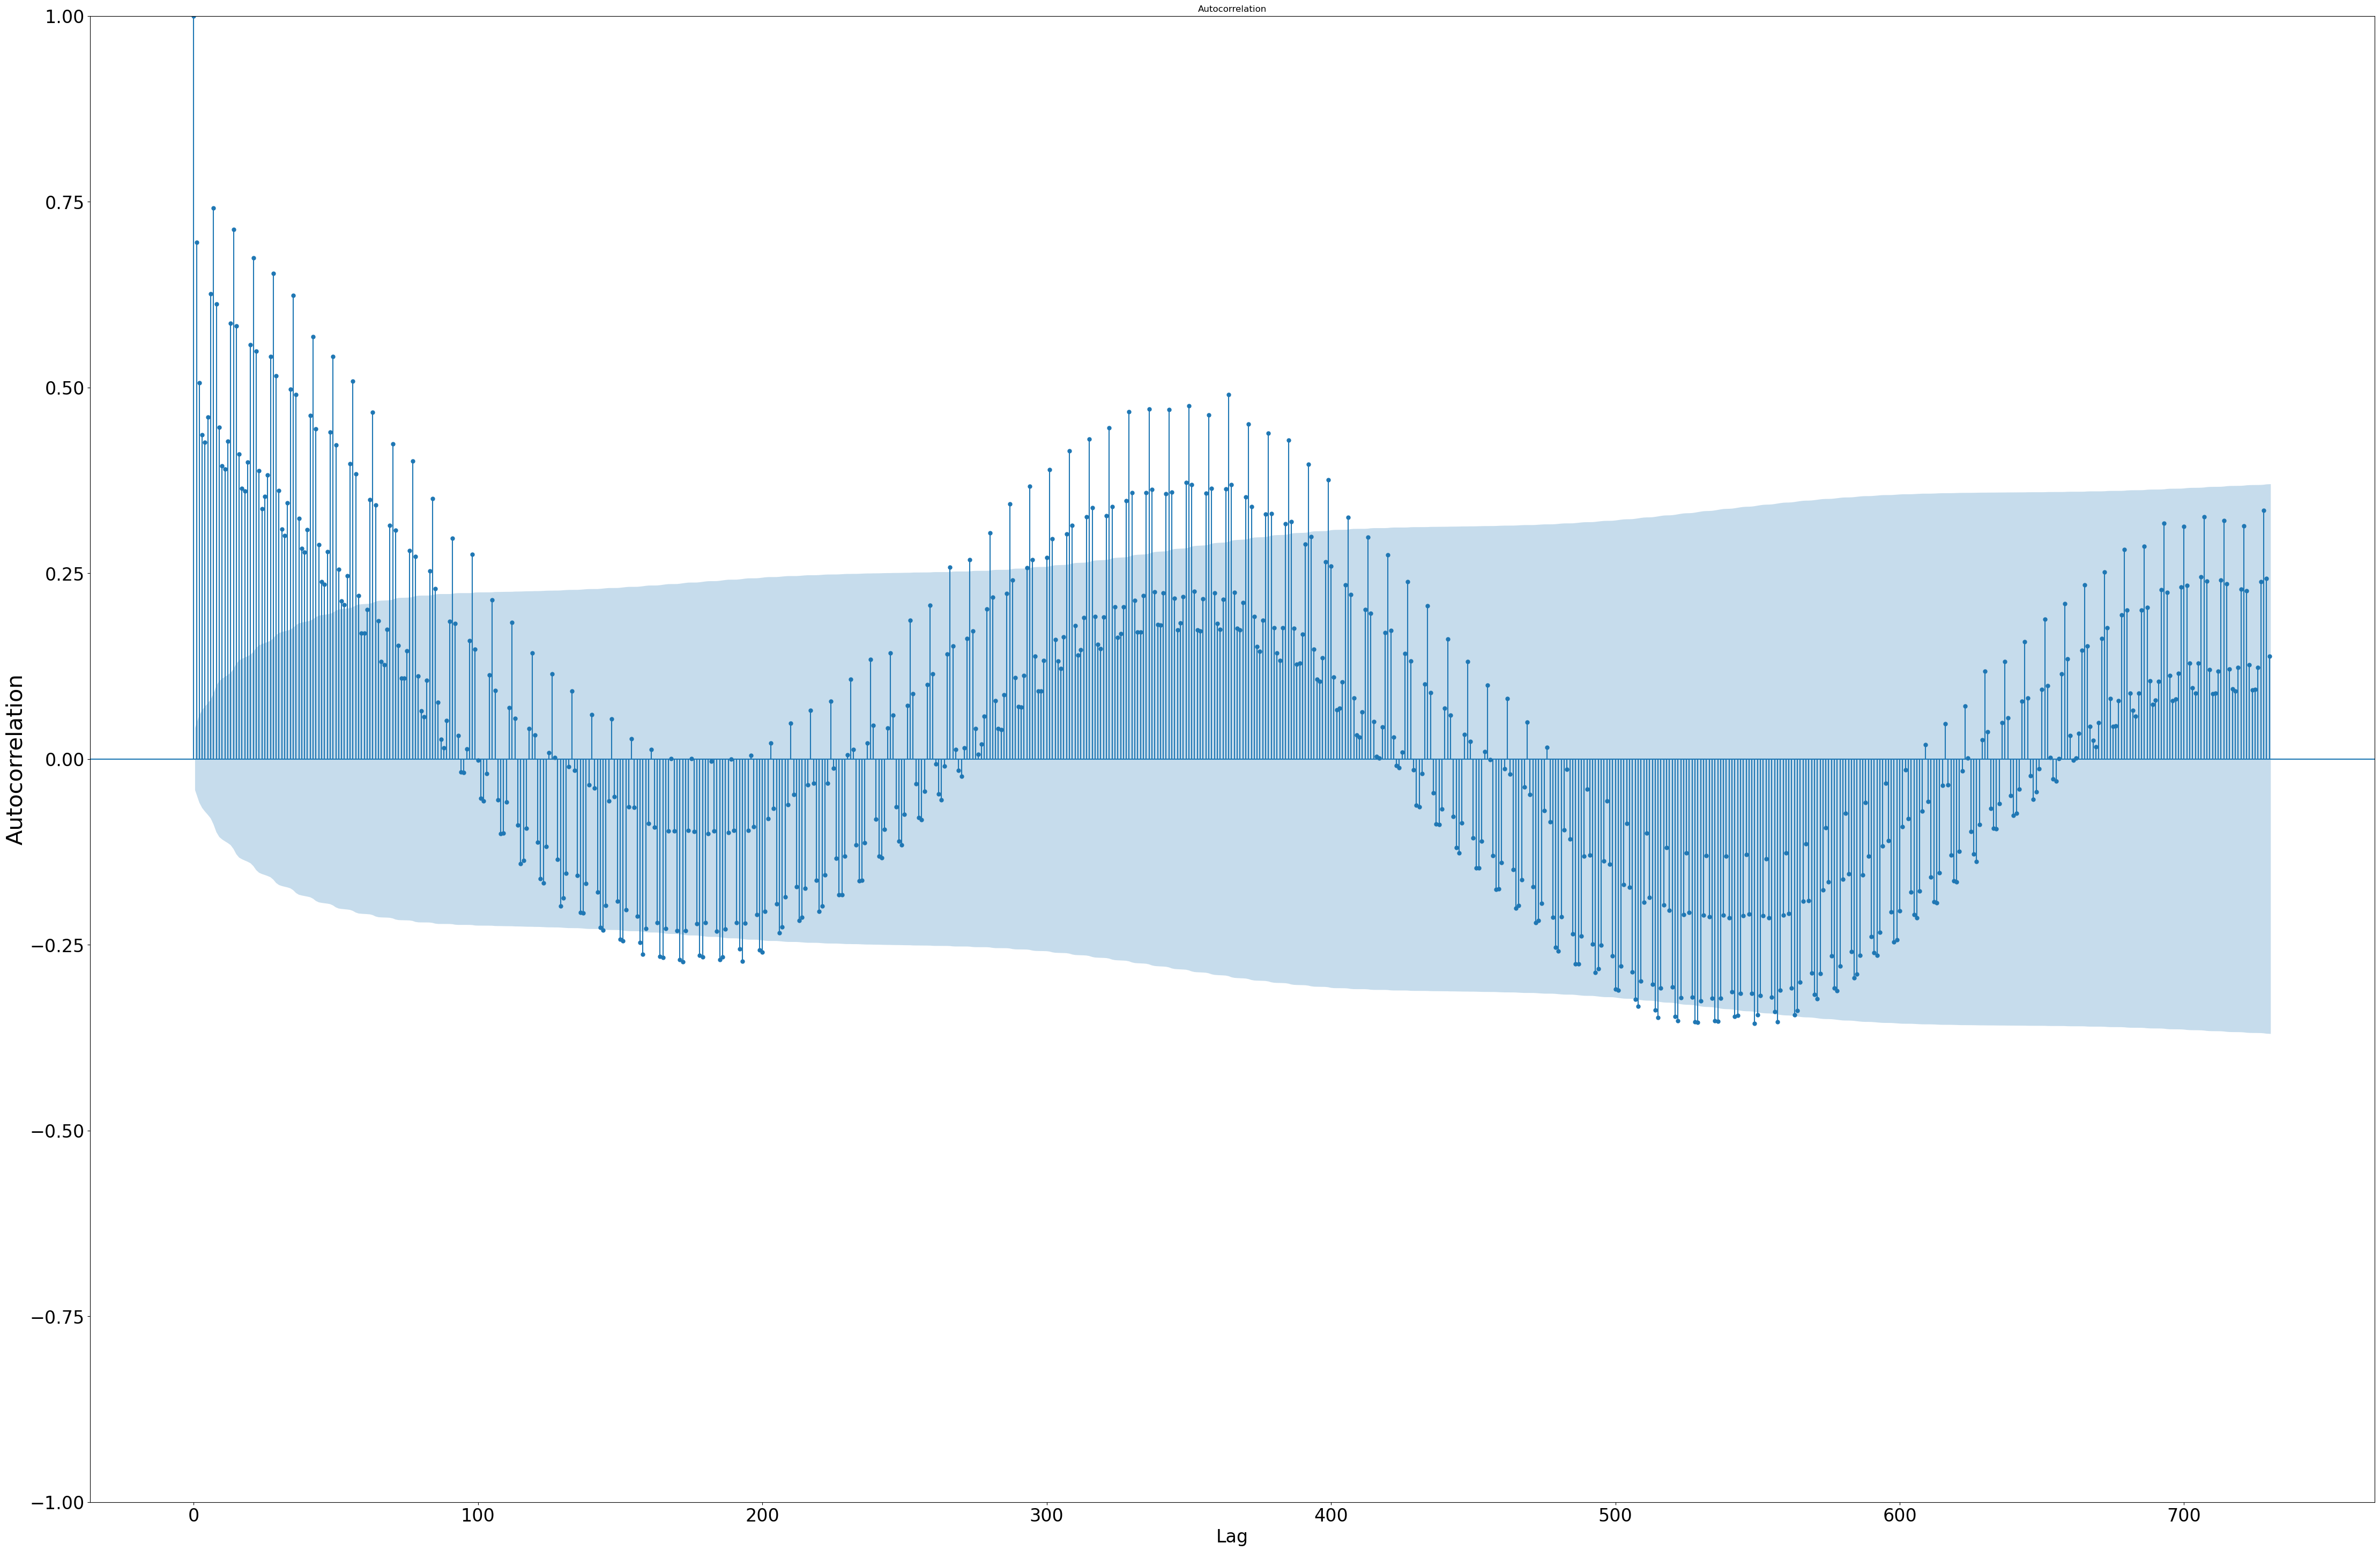

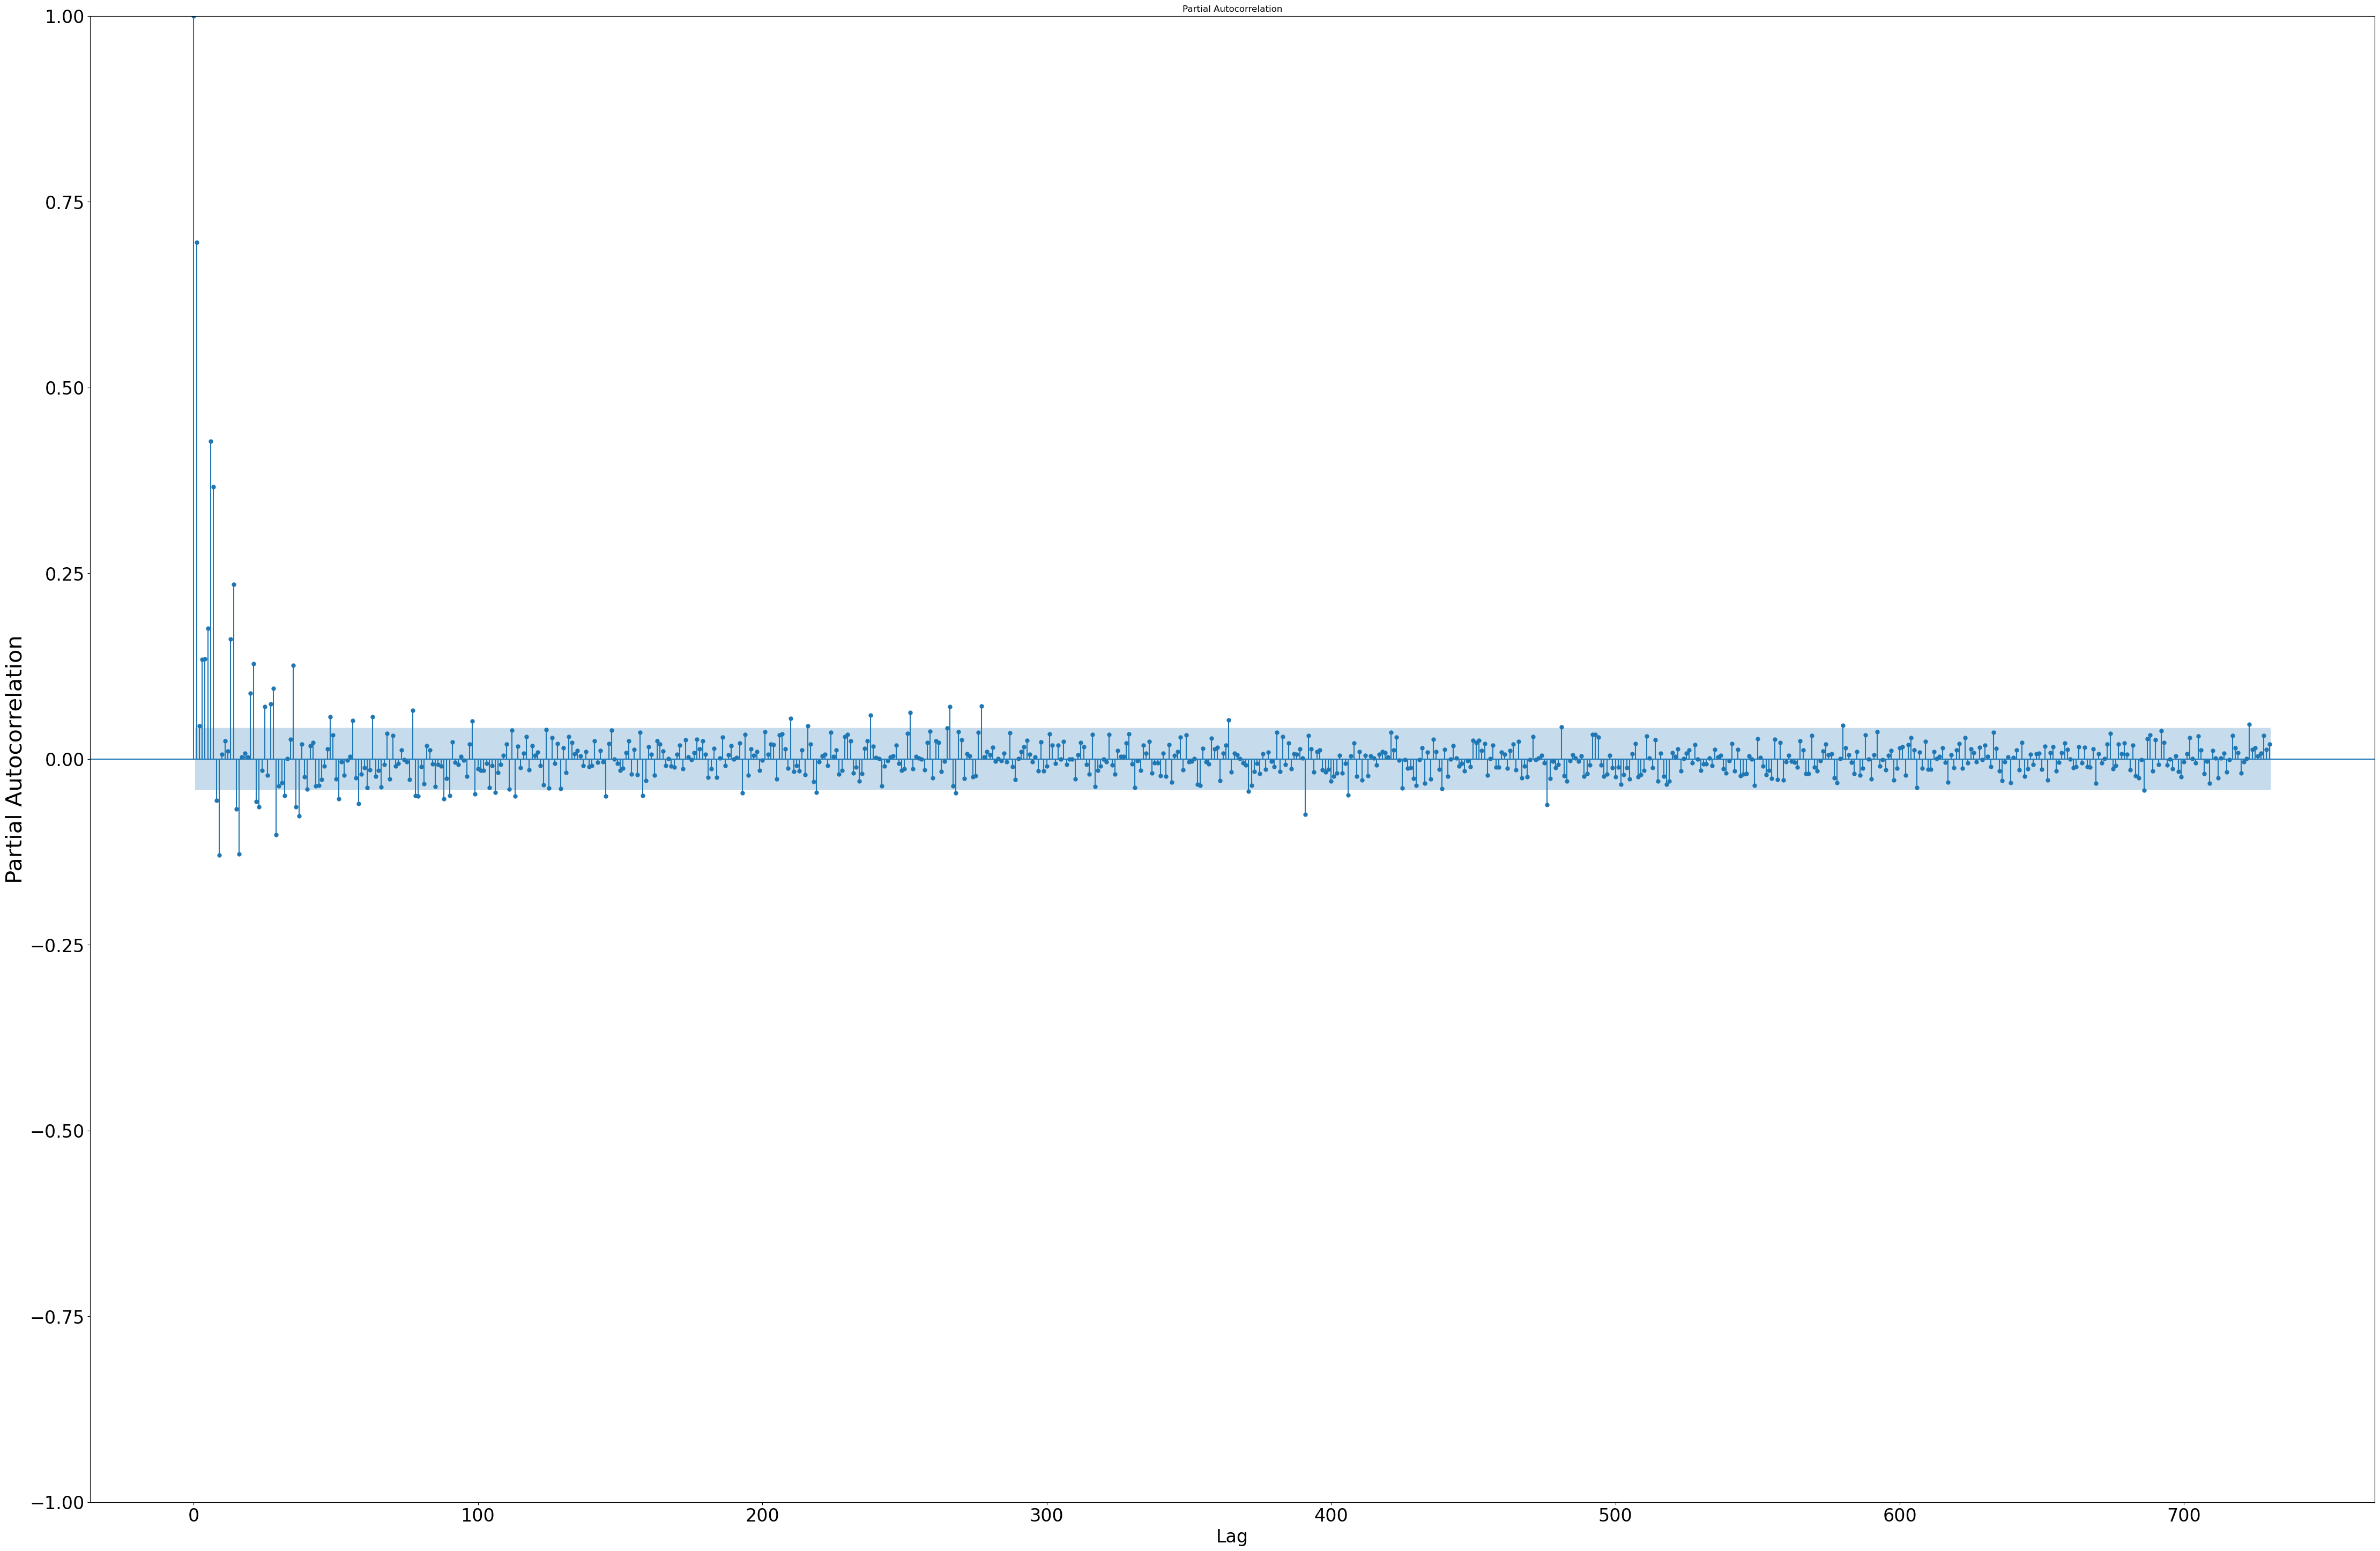

In [89]:
cdate_rat = rs.groupby(rs['created_date'].dt.date).size().reset_index(name='count')


fig, ax = plt.subplots(1, 1, figsize=(55,36))
sm.graphics.tsa.plot_acf(cdate_rat['count'], 
                         lags = 365*2,
                         ax=ax)
plt.xlabel("Lag",fontsize=24)
plt.ylabel("Autocorrelation",fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(55,36))
sm.graphics.tsa.plot_pacf(cdate_rat['count'], 
                         lags = 365*2,
                         ax=ax)
plt.xlabel("Lag",fontsize=24)
plt.ylabel("Partial Autocorrelation",fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [90]:
import statsmodels.tsa.api as sm
from pmdarima import auto_arima

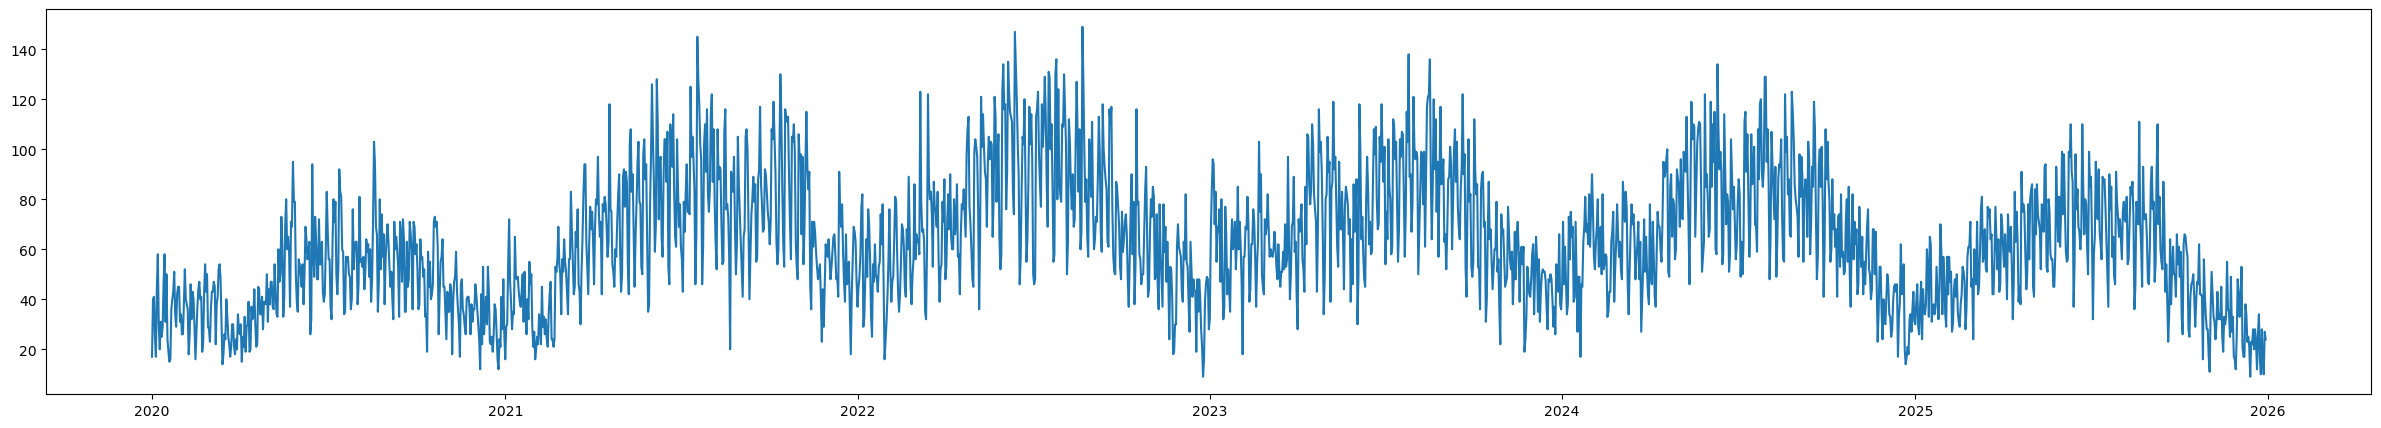

In [91]:
y = rs.groupby([rs['created_date'].dt.date]).size().reset_index(name='count')

full_range = pd.date_range(
    start="2020-01-01",
    end=y['created_date'].max(),
    freq='D'
)

# reindex and fill missing dates with 0
y = (
    y
    .set_index('created_date')
    .reindex(full_range, fill_value=0)
    .rename_axis('created_date')
    .reset_index()
)

plt.figure(figsize=(30,5))
plt.plot(y['created_date'], y['count'])
plt.show()

In [92]:
# a SARIMA model might not be the best for seasonality of 1 year with daily data.
# m = 7 is NOT appropriat here.

z = y['count'].to_numpy()
auto_arima(z, trace=True, error_action="ignore", stepwise=True, seasonal=True, m = 7)
# seasonal = True since we see seasonal behavior
# m=7 since our data is daily number of sightings
# see https://alkaline-ml.com/pmdarima/2.0.1/tips_and_tricks.html?highlight=seasonal

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=17556.913, Time=2.01 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=19317.614, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=18647.640, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=18560.794, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=19315.614, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=18333.420, Time=1.11 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=18112.389, Time=0.90 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=3.82 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=inf, Time=3.80 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=18461.377, Time=0.38 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=18151.247, Time=2.24 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=17893.161, Time=2.35 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=17560.701, Time=4.19 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=17557.626, Time=1.94 sec
 ARIMA(2,1,1)(1,0,1)[7] interce

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                 2191
Model:             ARIMA(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -8771.028
Date:                         Wed, 25 Feb 2026   AIC                          17554.056
Time:                                 09:34:26   BIC                          17588.206
Sample:                                      0   HQIC                         17566.537
                                        - 2191                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2487      0.024     10.432      0.000       0.202       0.295
ar.L2          0.0671      0.023      2.875      0.004     

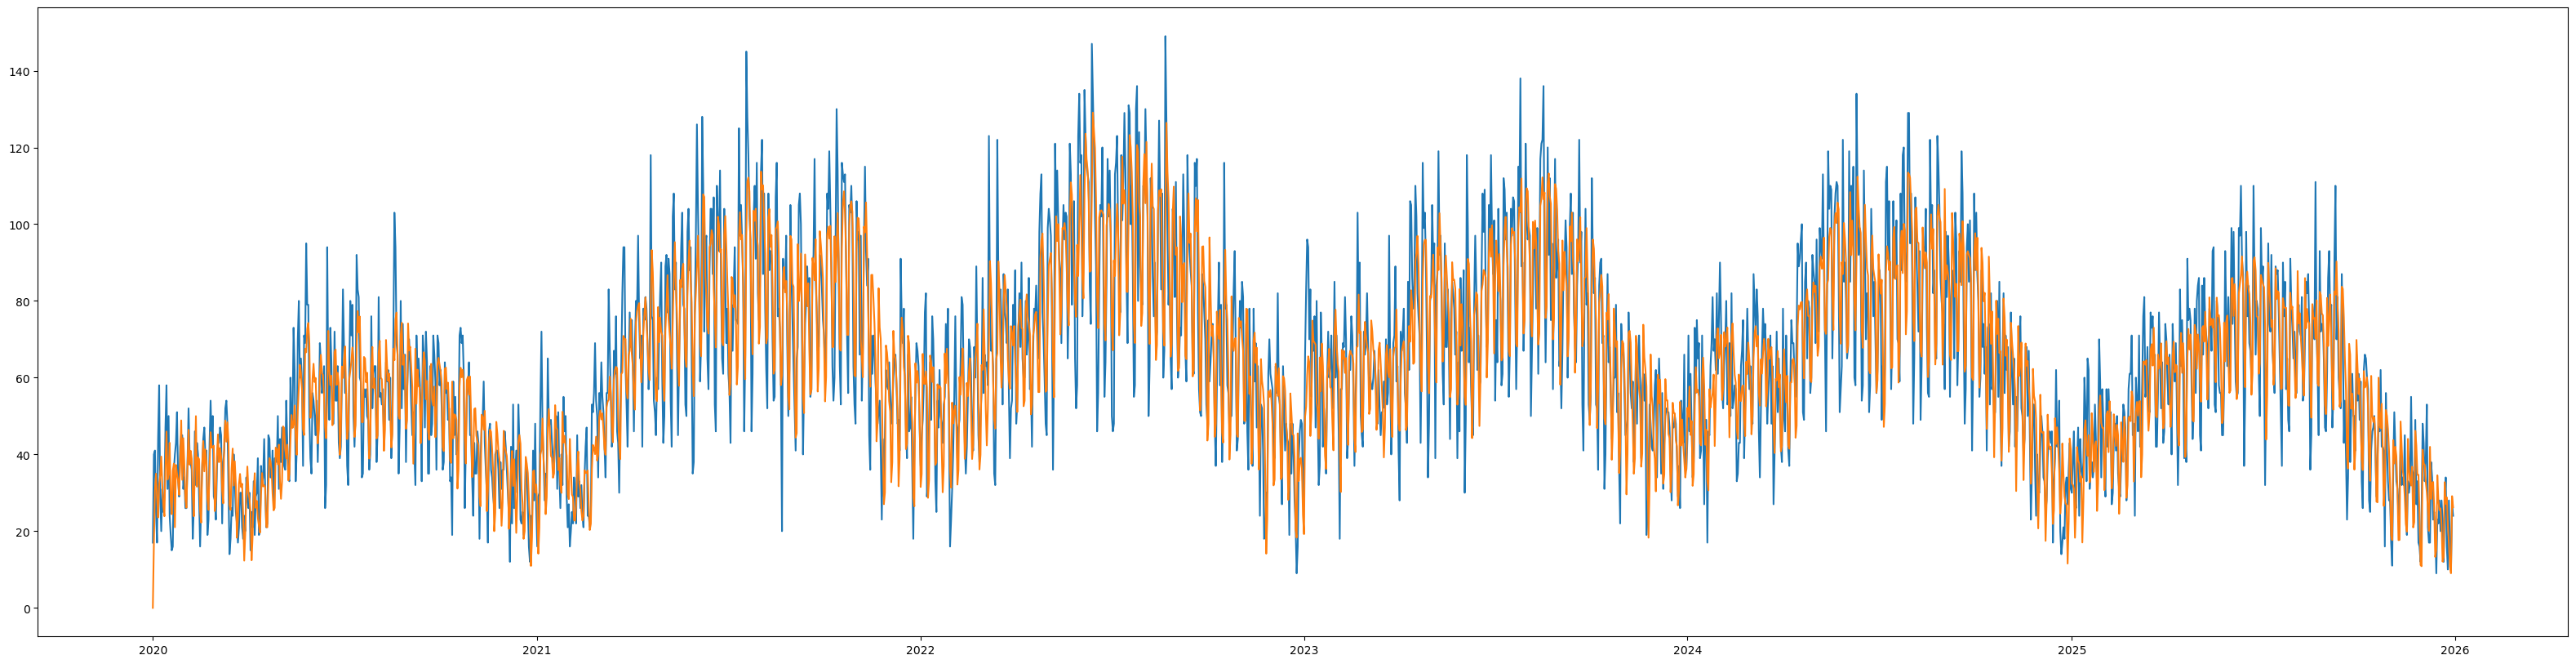



 The RMSE of our model against the the entire data set is 13.272032420239865

 The RSS of our model against the the entire data set is 621.2388722862573 


In [93]:
model = sm.ARIMA(z, order = (2, 1, 1), seasonal_order=(1,0,1,7)).fit()
print(model.summary())
plt.figure(figsize=(40,10))
plt.plot(y['created_date'], y['count'])
plt.plot(y['created_date'], model.fittedvalues)
plt.show()



rmse = np.sqrt(np.mean((y['count'] - model.fittedvalues)**2))
rss = np.sqrt(np.sum((y['count'] - model.fittedvalues)**2))
print(f"\n\n The RMSE of our model against the the entire data set is {rmse}")
print(f"\n The RSS of our model against the the entire data set is {rss} ")

# Nonlinear Regression on Fourier Series Models

In [94]:
df_train = nrs_train
df_test = nrs_test

We can use nonlinear regression and try to fit a model of the following form
$$
f(t) = \beta_0 + \beta_1t + \sum_{j=1}^T \left[ \phi_j \cos\left(\frac{2j\pi}{365} t\right) + \psi_j\sin\left(\frac{2j\pi}{365} t\right) \right]
$$
with a linear component to capture any upward trend, and a Fourier polynomial term to capture the periodic part. 

R² on training data: 0.3063
R² on testing data: 0.2046


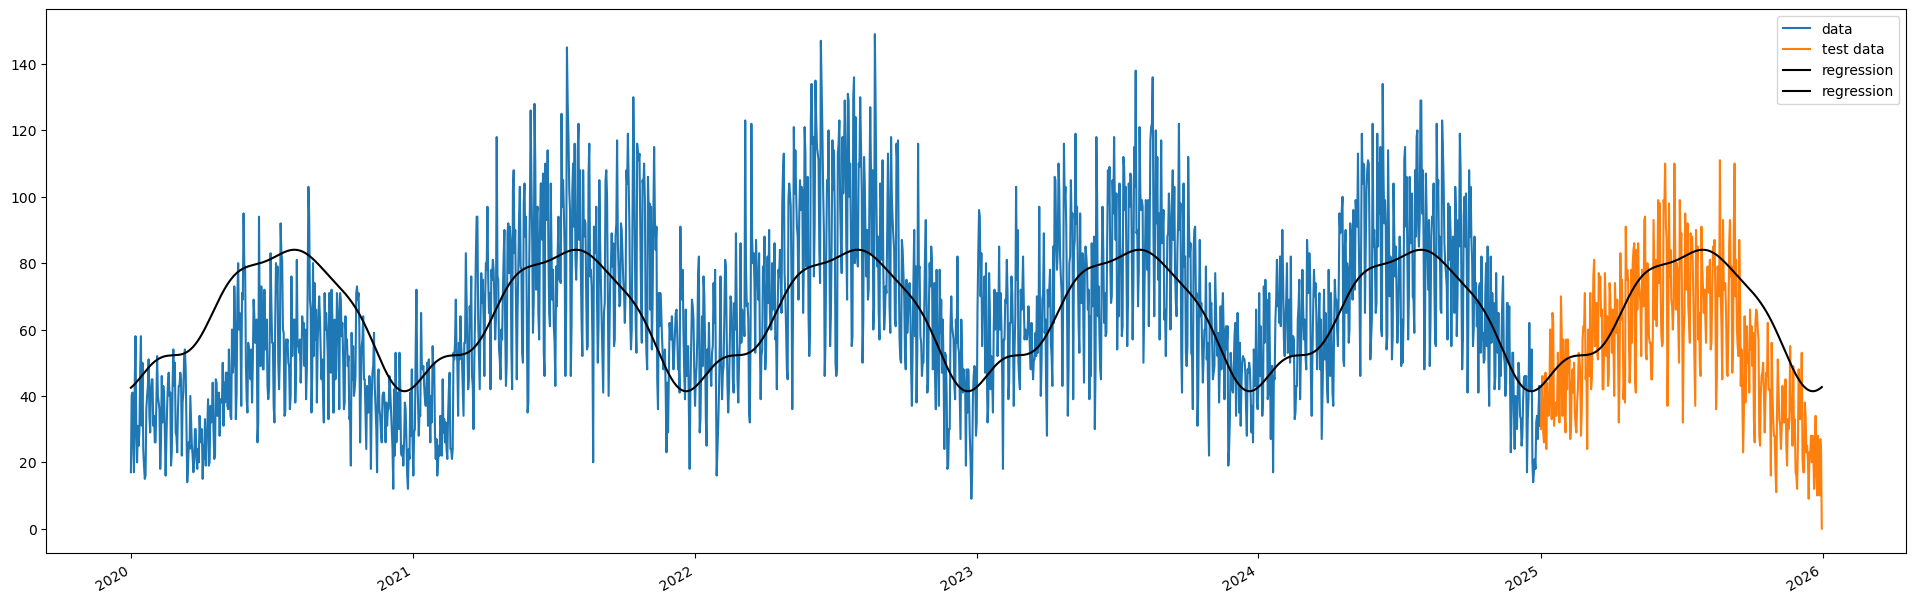



 The RMSE of our model against the the testing data is 19.395632287494557

 The RSS of our model against the the testing data set is 370.5530345558797



In [95]:
from sklearn.linear_model import LinearRegression


T = 5 # picks out the number of fourier terms

train_times = df_train.index.values
cosines = np.stack([np.cos(2*np.pi*train_times*j/365) for j in range(1,T)]  , axis = 1)
sines = np.stack([np.sin(2*np.pi*train_times*j/365) for j in range(1,T)]  , axis = 1)
train_features = np.concatenate([cosines, sines], axis = 1)

lr = LinearRegression()
lr.fit(train_features,df_train['count'])
lr_train_preds = lr.predict(train_features)


train_r2 = lr.score(train_features, df_train['count'])
print(f"R² on training data: {train_r2:.4f}")



test_times = df_test.index.values
n_train = len(df_train)
test_times = np.arange(n_train, n_train + len(df_test)) 
cosines_test = np.stack([np.cos(2*np.pi*test_times*j/365) for j in range(1,T)], axis=1)
sines_test = np.stack([np.sin(2*np.pi*test_times*j/365) for j in range(1,T)], axis=1)
test_features = np.concatenate([cosines_test, sines_test], axis=1)


test_r2 = lr.score(test_features, df_test['count'])
print(f"R² on testing data: {test_r2:.4f}")

lr_test_preds = lr.predict(test_features)



fig = plt.figure(figsize=(24,8))
plt.plot(df_train['created_date'], df_train['count'], label = 'data')
plt.plot(df_test['created_date'], df_test['count'], label='test data')
plt.plot(df_train['created_date'], lr_train_preds, 'k',label = 'regression')
plt.plot(df_test['created_date'],lr_test_preds,'k', label='regression' )


plt.gcf().autofmt_xdate()
plt.legend()
plt.show()


rmse = np.sqrt(np.mean((df_test['count'] - lr_test_preds)**2))
rss = np.sqrt(np.sum((df_test['count'] - lr_test_preds)**2))
print(f"\n\n The RMSE of our model against the the testing data is {rmse}")
print(f"\n The RSS of our model against the the testing data set is {rss}\n")


We observe that even as we increase $T$, the modeling actually doesn't do significantly better whatsover as the following table will show. In fact, it actually starts doing worse on the test data due to overfitting to the training data!

In [96]:
results = []
for T in range(2,60):

    train_times = df_train.index.values
    cosines = np.stack([np.cos(2*np.pi*train_times*j/365) for j in range(1,T)]  , axis = 1)
    sines = np.stack([np.sin(2*np.pi*train_times*j/365) for j in range(1,T)]  , axis = 1)
    train_features = np.concatenate([cosines, sines], axis = 1)

    lr = LinearRegression()
    lr.fit(train_features,df_train['count'])
    lr_train_preds = lr.predict(train_features)


    train_r2 = lr.score(train_features, df_train['count'])

    test_times = df_test.index.values
    n_train = len(df_train)
    test_times = np.arange(n_train, n_train + len(df_test)) 
    cosines_test = np.stack([np.cos(2*np.pi*test_times*j/365) for j in range(1,T)], axis=1)
    sines_test = np.stack([np.sin(2*np.pi*test_times*j/365) for j in range(1,T)], axis=1)
    test_features = np.concatenate([cosines_test, sines_test], axis=1)


    test_r2 = lr.score(test_features, df_test['count'])
    lr_test_preds = lr.predict(test_features)


    rmse = np.sqrt(np.mean((df_test['count'] - lr_test_preds)**2))
    rss = np.sqrt(np.sum((df_test['count'] - lr_test_preds)**2))

    results.append({
        'T': T,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Test RMSE': rmse,
        'Test RSS': rss
    })

results_df = pd.DataFrame(results)
display(results_df)

T  Train R²   Test R²  Test RMSE    Test RSS
0    2  0.296412  0.194058  19.524349  373.012156
1    3  0.299346  0.208412  19.349696  369.675418
2    4  0.303014  0.211775  19.308556  368.889451
3    5  0.306253  0.204650  19.395632  370.553035
4    6  0.307951  0.197629  19.481043  372.184806
5    7  0.308871  0.200222  19.449537  371.582884
6    8  0.309805  0.196904  19.489844  372.352943
7    9  0.311593  0.202466  19.422243  371.061427
8   10  0.311987  0.199938  19.453000  371.649051
9   11  0.313040  0.198981  19.464627  371.871175
10  12  0.315345  0.193094  19.536020  373.235137
11  13  0.317156  0.196659  19.492819  372.409787
12  14  0.318494  0.193766  19.527885  373.079720
13  15  0.321897  0.188108  19.596286  374.386510
14  16  0.322312  0.190553  19.566763  373.822478
15  17  0.322685  0.190766  19.564190  373.773323
16  18  0.323344  0.189943  19.574127  373.963173
17  19  0.324353  0.192623  19.541724  373.344115
18  20  0.326058  0.193107  19.535869  373.232249
19  21  0.326735  0.191557  19.554615  373.590403
20  22  0.328429  0.188102  19.596355  374.387831
21  23  0.329901  0.186346  19.617543  374.792634
22  24  0.330584  0.184538  19.639323  375.208739
23  25  0.330586  0.184585  19.638760  375.197975
24  26  0.330885  0.181121  19.680426  375.994018
25  27  0.332507  0.180840  19.683809  376.058641
26  28  0.333300  0.177381  19.725325  376.851808
27  29  0.333583  0.176936  19.730658  376.953686
28  30  0.335059  0.175562  19.747116  377.268127
29  31  0.336122  0.172199  19.787350  378.036784
30  32  0.336875  0.168905  19.826685  378.788284
31  33  0.336976  0.168859  19.827229  378.798684
32  34  0.337121  0.167550  19.842832  379.096766
33  35  0.337180  0.168082  19.836490  378.975601
34  36  0.337806  0.164331  19.881170  379.829217
35  37  0.337830  0.164274  19.881841  379.842039
36  38  0.338527  0.164346  19.880986  379.825695
37  39  0.339168  0.164621  19.877718  379.763273
38  40  0.339328  0.163441  19.891754  380.031421
39  41  0.339755  0.163569  19.890231  380.002332
40  42  0.340149  0.162613  19.901587  380.219295
41  43  0.340248  0.163715  19.888495  379.969161
42  44  0.340894  0.163991  19.885204  379.906290
43  45  0.341388  0.163875  19.886592  379.932800
44  46  0.341538  0.164146  19.883359  379.871043
45  47  0.342562  0.163351  19.892823  380.051853
46  48  0.344094  0.163843  19.886969  379.940005
47  49  0.344182  0.163043  19.896484  380.121792
48  50  0.345685  0.163991  19.885207  379.906351
49  51  0.345968  0.164307  19.881456  379.834680
50  52  0.346124  0.163701  19.888653  379.972190
51  53  0.377295 -0.011102  21.868660  417.800169
52  54  0.380040 -0.029578  22.067561  421.600152
53  55  0.380177 -0.028963  22.060963  421.474105
54  56  0.380466 -0.028659  22.057705  421.411860
55  57  0.380671 -0.027242  22.042509  421.121537
56  58  0.380705 -0.027227  22.042351  421.118532
57  59  0.380822 -0.027420  22.044420  421.158046